In [1]:
import numpy as np
import pyhit
import moosetree

In [2]:
'''Domain'''

x_a = 0
x_b = 0.05

x_length = x_b - x_a

In [3]:
'''Parameters and data'''

diff_coeff = 31
#source_s = 22028049
source_s = 156940

u_a = 20
u_b = 40

In [4]:
'''FEM Solution'''

n_felem = 10

order = 'second'
flux_order = 'first'
n_plot_pts = n_felem + 1
n_plot_pts = 2000

In [5]:
'''Write input file function'''
def write_input_file():
    import pyhit
    import moosetree
    root = pyhit.load('')

    prblm = root.insert(-1,'Problem')
    prblm['type'] = 'FEProblem'
    prblm['coord_type'] = 'XYZ'

    mesh = root.insert(-1,'Mesh')
    
    omega = mesh.insert(-1,'omega')
    omega['type'] = 'GeneratedMeshGenerator'
    omega['dim'] = 1
    omega['xmin'] = x_a
    omega['xmax'] = x_b
    omega['nx'] = n_felem
    if order == 'second':
        omega['elem_type'] = 'edge3'

    vars = root.insert(-1,'Variables')
    
    conc = vars.insert(-1,'u')
    conc['order'] = order
    conc['family'] = 'lagrange'
    conc['initial_condition'] = (u_a+u_b)/2
    
    kernels = root.insert(-1,'Kernels')
    
    diff = kernels.insert(-1,'diffusion-term')
    diff['type'] = 'DiffusionTerm'
    diff['variable'] = 'u'
    #diff['alfa'] =174686
    #diff['beta'] =25777
    diff['diffCoeff']=31
    
    source = kernels.insert(-1,'source-term')
    source['type'] = 'SourceTerm'
    source['variable'] = 'u'
    source['sourceS'] = source_s
    source['coupledVariable'] = 'u'
    
    aux_vars = root.insert(-1,'AuxVariables')
    
    heat_flux_fuel = aux_vars.insert(-1,'diffFluxU')
    heat_flux_fuel['order'] = flux_order
    heat_flux_fuel['family'] = 'monomial_vec'
    
    heat_flux_fuel_r = aux_vars.insert(-1,'diffFluxU_r')
    heat_flux_fuel_r['order'] = flux_order
    heat_flux_fuel_r['family'] = 'monomial'
    
    aux_kernels = root.insert(-1,'AuxKernels')
        
    heat_flux = aux_kernels.insert(-1,'heat-flux-fuel')
    heat_flux['type'] = 'HeatFlux'
    heat_flux['field'] = 'u'
    heat_flux['thCondCoeff'] = diff_coeff
    heat_flux['variable'] = 'diffFluxU'
    heat_flux['execute_on'] = 'timestep_end'
    
    heat_flux_r = aux_kernels.insert(-1,'heat-flux-fuel-r')
    heat_flux_r['type'] = 'VectorVariableComponentAux'
    heat_flux_r['vector_variable'] = 'diffFluxU'
    heat_flux_r['component'] = 'x'
    heat_flux_r['variable'] = 'diffFluxU_r'
    heat_flux_r['execute_on'] = 'timestep_end'
    
    
    bcs = root.insert(-1,'BCs')
    
    
    xa = bcs.insert(-1,'entry-u')
    xa['type'] = 'NormalHeatFluxBC'
    xa['variable'] = 'u'
    xa['boundary'] = 'left'
    xa['bias'] = 0
    xa['transferCoeff'] = -10
    xa['refTempFunc'] = 20
    
    xb = bcs.insert(-1,'exit-u')
    xb['type'] = 'NormalHeatFluxBC'
    xb['variable'] = 'u'
    xb['boundary'] = 'right'
    xb['bias'] = 0
    xb['transferCoeff'] = -10
    xb['refTempFunc'] = 40
    
    """
    xa = bcs.insert(-1,'entry-u')
    xa['type'] = 'DirichletBC'
    xa['variable'] = 'u'
    xa['boundary'] = 'left'
    xa['value'] = u_a
    #xa['transferCoeff'] = -10
    #xa['refTempFunc'] = 25
    
    xb = bcs.insert(-1,'exit-u')
    xb['type'] = 'DirichletBC'
    xb['variable'] = 'u'
    xb['boundary'] = 'right'
    xb['value'] = u_b
    #xb['transferCoeff'] = -10
    #xb['refTempFunc'] = 15
    """


    exe = root.insert(-1,'Executioner')
    exe['type'] = 'Steady'
    exe['solve_type']  = 'PJFNK'
    exe['petsc_options_iname']  = '-pc_type -pc_hypre_type'
    exe['petsc_options_value']  = 'hypre boomeramg'
    exe['l_max_its']  = 20
    exe['l_tol']  = 1e-5
    exe['nl_max_its']  = 15
    exe['nl_rel_tol']  = 1e-8
    exe['nl_abs_tol']  = 1e-8

    vp = root.insert(-1,'VectorPostprocessors')
    omega = vp.insert(-1,'Robin_constant')
    omega['type'] = 'LineValueSampler'
    omega['execute_on'] = 'timestep_end final'
    omega['variable'] = 'u diffFluxU_r'
    #omega['variable'] = 'u'  
    omega['start_point'] = str(x_a)+' 0 0'
    omega['end_point'] = str(x_b)+' 0 0'
    omega['num_points'] = n_plot_pts
    omega['sort_by'] = 'id'

    out = root.insert(-1,'Outputs')
    out['console'] = 'true'
    csv = out.insert(-1,'csv')
    csv['type'] = 'CSV'
    csv['file_base'] = 'output'
    csv['execute_on'] = 'final'

    pyhit.write('input_variable_k.hit', root)

In [6]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [m]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [C]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_r' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_r'],'*-', color='yellow', label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

In [7]:
'''Write input file'''
write_input_file()

In [8]:
'''Display MOOSE input file created'''

!cat input_variable_k.hit

[Problem]
  type = FEProblem
  coord_type = XYZ
[]
[Mesh]
  [omega]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 0
    xmax = 0.05
    nx = 10
    elem_type = edge3
  []
[]
[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = 30.0
  []
[]
[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u
    diffCoeff = 31
  []
  [source-term]
    type = SourceTerm
    variable = u
    sourceS = 156940
    coupledVariable = u
  []
[]
[AuxVariables]
  [diffFluxU]
    order = first
    family = monomial_vec
  []
  [diffFluxU_r]
    order = first
    family = monomial
  []
[]
[AuxKernels]
  [heat-flux-fuel]
    type = HeatFlux
    field = u
    thCondCoeff = 31
    variable = diffFluxU
    execute_on = timestep_end
  []
  [heat-flux-fuel-r]
    type = VectorVariableComponentAux
    vector_variable = diffFluxU
    component = x
    variable = diffFluxU_r
    execute_on = timestep_end
  []
[]
[BCs]
  [entry-u]
    type = NormalHeatFluxBC
    var

In [9]:
'''Run Engy5310P1 MOOSE App'''

#!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit

!/Users/joker/softwears/moose/engy5310p1/engy5310p1-opt -i input_variable_k.hit




*** Warning, This code is deprecated and will be removed in future versions:
The following object(s) are constructed using the legacy input parameter construction:

  DiffusionTerm (Engy5310P1App)
  EquationFluxBC (Engy5310P1App)
  FluxComponent (Engy5310P1App)
  InterfacePartition (Engy5310P1App)
  NormalHeatFluxBC (Engy5310P1App)
  SourceTerm (Engy5310P1App)

Convert InputParameters validParams<T>() for each object into a static
member function InputParameters T::validParams() and remove the old function.

See mooseframework.org/newsletter/2021_11.html#legacy-input-parameter-deprecation
for more information.

Stack frames: 10
0: 0   libmesh_opt.0.dylib                 0x0000000111d6ae23 libMesh::print_trace(std::__1::basic_ostream<char, std::__1::char_traits<char> >&) + 1091
1: 1   libmoose-opt.0.dylib                0x000000010f1857ee void moose::internal::mooseDeprecatedStream<libMesh::BasicOStreamProxy<char, std::__1::char_traits<char> >, std::__1::basic_string<char, std::__1::

      diffFluxU_r        id           u         x  y  z
0    -4022.700000  0.000000  422.270000  0.000000  0  0
1    -4018.774537  0.000025  422.273244  0.000025  0  0
2    -4014.849074  0.000050  422.276485  0.000050  0  0
3    -4010.923612  0.000075  422.279723  0.000075  0  0
4    -4006.998149  0.000100  422.282958  0.000100  0  0
...           ...       ...         ...       ... .. ..
1995  3808.598149  0.049900  422.442317  0.049900  0  0
1996  3812.523612  0.049925  422.439243  0.049925  0  0
1997  3816.449074  0.049950  422.436165  0.049950  0  0
1998  3820.374537  0.049975  422.433084  0.049975  0  0
1999  3824.300000  0.050000  422.430000  0.050000  0  0

[2000 rows x 6 columns]


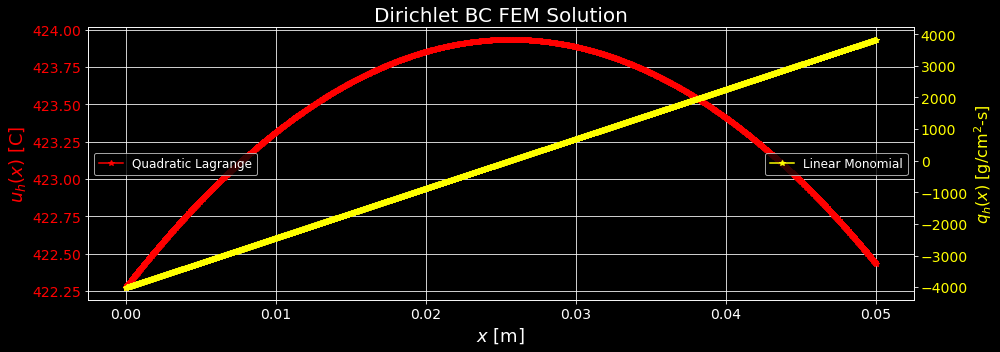

In [10]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_Robin_constant_0002.csv')
print(df)   
plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

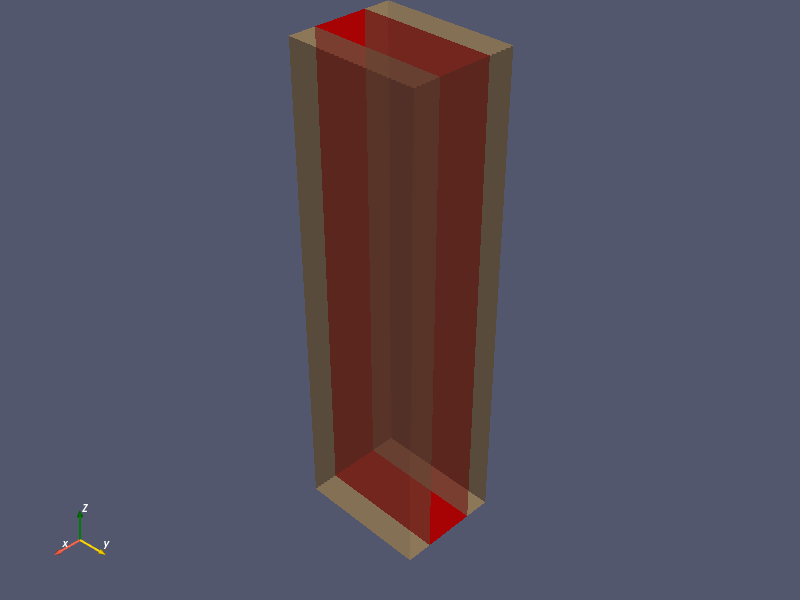

In [30]:
import pyvista as pv
def show_domain(screenshot=False):
   
    pv.set_plot_theme('paraview')

    
    #coolant = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=height, radius=radius_i)
    brick1=pv.Box(bounds=(0.0, 4, 0.0, 6, 0.0, 18.0), level=2, quads=True,)
    air1=pv.Box(bounds=(1, 3, 2, 4, 0.0, 18.0), level=2, quads=True,)
    #air2=pv.Box(bounds=(1, 1.5, 0, 5, 0.0, 18.0), level=0, quads=True,)
    brick2=pv.Box(bounds=(0.4, 8, 0.0, 6, 0.0, 18.0), level=2, quads=True,)
    air2=pv.Box(bounds=(5, 7, 2, 4, 0.0, 18.0), level=2, quads=True,)
    #fir 3D cross-section
    air3=pv.Box(bounds=(0, -1, 0, 5, 0.0, 18.0), level=0, quads=True,)
    brick3=pv.Box(bounds=(0.0, 2, 0.0, 5, 0.0, 18.0), level=2, quads=True,)
    air4=pv.Box(bounds=(2, 3, 0, 5, 0.0, 18.0), level=0, quads=True,)
    plo = pv.Plotter(notebook=True, shape=(1,2))
    plo = pv.Plotter(shape=(1,1)) 


    
    plo.add_mesh(brick3, color='red', opacity=.80)
    #plo.add_mesh(air1, color='tan', opacity=0.99)
    plo.add_mesh(air3, color='tan', opacity=.99)
    #plo.add_mesh(brick2, color='red', opacity=.80)
    #plo.add_mesh(air1, color='tan', opacity=0.99)
    plo.add_mesh(air4, color='tan', opacity=.99)
    plo.add_axes(xlabel='x', ylabel='y', zlabel='Z')
    
    cpos = plo.show(window_size=[800, 600])
    if screenshot:
        plo.screenshot('domain.png')
show_domain()

In [27]:
show_domain()

In [13]:
bricks = pyvista.Box(bounds=(0.0, 4, 0.0, 5, 0.0, 18.0),level=1)
air1=pyvista.Box(bounds=(0.1, 4, 0.0, 5, 0.0, 18.0),level=0)
#plo = pv.Plotter(shape=(1,1))
#plo.add_mesh(bricks, color='red', opacity=1.0)
bricks.plot(show_edges=True,color='red')
air1.plot(show_edges=True,color='black')

#cpos = plo.show(window_size=[800, 600])
#show_domain()

NameError: name 'pyvista' is not defined